# H1st ML Model Guide

The H1st Model is one of the core concepts of H1st, and it is central to the way H1st works. Model presents a uniform interface to its users, whether the underlying model is boolean logic, fuzzy logic derived from human’s intuition, a Scikit-learn random forest, or a Tensorflow neural network. This makes it possible for you to use and combine Models in Graphs or Ensembles easily.

The easiest way to understand H1st model is actually implementing it. H1st model provides all the interfaces to manage the life cycle of the model. 

Below is an example of H1st Model that utilizes an underlying Scikit-learn model for digits classification.

In [1]:
"""
This is an example of a very simple H1st ML model.
We demonstrate here how to wrap a ScikitLearn model within an h1.Model
"""

from sklearn import svm, datasets, metrics
from h1st.model.ml_model import MLModel


class SimpleMLModel(MLModel):
    def __init__(self):
        # H1st can automatically save/load this "self.base_model" property if it's a SKlearn or tf.keras.Model
        # This is the native SKLearn model
        self.base_model = svm.SVC(gamma=0.001, C=100.)

    def get_data(self):
        digits = datasets.load_digits()
        return {
            "x": digits.data,
            "y": digits.target
        }

    def explore_data(self, data):
        pass

    def prep(self, data):
        x = data["x"]
        y = data["y"]
        num_tests = 10
        return {
            "train_x": x[num_tests:],
            "train_y": y[num_tests:],
            "test_x": x[0:num_tests],
            "test_y": y[0:num_tests]
        }

    def train(self, prepared_data):
        self.base_model.fit(prepared_data["train_x"], prepared_data["train_y"])

    def evaluate(self, data):
        pred_y = self.predict({"x": data["test_x"]})
        # self.metrics can also be persisted automatically by H1st
        self.metrics = metrics.accuracy_score(data["test_y"], pred_y)
        return self.metrics

    def predict(self, input_data: dict) -> dict:
        """
        We expect an array of input data rows in the "x" field of the input_data dict
        """
        return self.base_model.predict(input_data["x"])

2023-02-17 10:50:27.182315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 10:50:27.272840: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 10:50:27.272858: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-17 10:50:27.825969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

To create an H1st model, you can start by create a new class and subclass from the `h1.Model`.

Then we populate the methods to `get_data()` to get the data, `prep()` to preprocess it, and of course `train()`, `evaluate()` and `predict()`.

This is how the model is used. Pay close attention to the parameters of the methods and note that the train-val data splitting is done in prep(), and that most `data` parameters should be Python dictionaries where the data scientists can creatively decide how to use the keys & values such as `train_x`, `test_x`.

In [2]:
# ML Modelのインスタンスを作成します。
m = SimpleMLModel()

In [3]:
# get_data()メソッドはsklearnの手書き数字データセットを返します。
raw_data = m.get_data()
# dict形式で、キー'x'には手書きデータが、キー'y'には正解データが格納されています。
print(type(raw_data))
print(raw_data)

<class 'dict'>
{'x': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]]), 'y': array([0, 1, 2, ..., 8, 9, 8])}


In [4]:
# ひとつのデータの例
print(raw_data['x'][2])
print(raw_data['y'][2])

[ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
  8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
 15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
  5.  0.  0.  0.  0.  3. 11. 16.  9.  0.]
2


<Figure size 640x480 with 0 Axes>

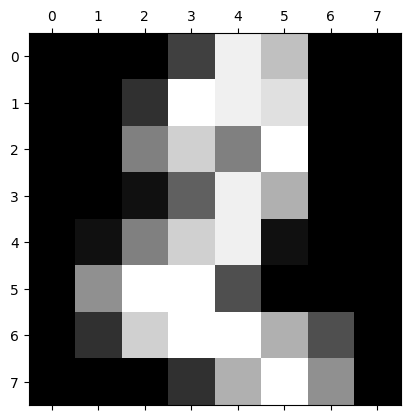

In [5]:
# 試しに表示してみる
import matplotlib
import matplotlib.pyplot as plt

plt.gray()
plt.matshow(raw_data['x'][2].reshape(8,8))
plt.show()

In [6]:
# prep()は1797個の手書きデータを、1787個の学習用と、10個のテスト用に分割する
prepared_data = m.prep(raw_data)
print(prepared_data['train_x'].shape)  # 学習用手書きデータ
print(prepared_data['train_y'].shape)  # 学習用正解データ
print(prepared_data['test_x'].shape)   # テスト用手書きデータ
print(prepared_data['test_y'].shape)   # テスト用正解データ

(1787, 64)
(1787,)
(10, 64)
(10,)


In [7]:
# 学習を実行
m.train(prepared_data)
# テストを実行
m.evaluate(prepared_data)
# 正答率
print("accuracy_score = %.4f" % m.metrics)

accuracy_score = 0.9000


このAPIの良いところは、boolean/fuzzy logic や ML modelsなど、どんなモデルでもそのワークフローを保存できることである。

In [8]:
# ここまでの結果をModelレポジトリに保存する
version_id = m.persist()    # IDは自動付与される
#version_id = m.persist('000VERSION')  # このようにIDを指定することもできる
print("Persisted to version_id = %s" % version_id)

Persisted to version_id = 01GSEH1ZYP25A6XR3AQKNZF0B3


In [9]:
# version_idを使って結果を参照できる
#m = MLModel().load(version_id)    # この書き方は間違い
m.load(version_id)
print(m.metrics)

0.9


H1st AI supports out-of-the-box easy persisting & loading of `sklearn` and `tf.keras` models to a model repository (other types can be added).

This makes it much easier to include model in larger workflows such as in H1st Graphs or Ensembles. It can enable data science teams to be much more productive.

A model repository is simply a folder on local disk or S3. We call `h1.init()` specifying `MODEL_REPO_PATH`. Alternative it can be automatically picked up in the project's `config.py`.